In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Install graphviz on your system from terminal (pip install graphviz)
from graphviz import Digraph

def trace(root) :
    # builds a set of all nodes and edges in a graph
    nodes, edges = set (), set ()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges. add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node (name = uid, label = " %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #backpropagation, by default nothing to do
        self._prev = set(_children) #record the children
        self._op = _op
        self.label = label
    
    #repr makes the printed values readable
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    #use double score in phyton to change default operators
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #this enables inline operation on Value like a+1
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # = instead of += below in original implementation
            self.grad += 1.0 * out.grad  #transfer grad + bugfix accumulate due to multivariable case of chain rule
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): #this is for reserve order mult like 2+a, since above only works a.__add__(2) but not in reserve
        return self * other
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) #this enables inline operation on Value like a*2
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # = instead of += below in original implementation
            self.grad += other.data * out.grad #chainrule + bugfix: accumulate due to multivariable case of chain rule
            other.grad += self.data * out.grad 
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): #this is for reserve order mult like 2*a, since above only works a.__mul__(2) but not in reserve
        return self * other
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad #derivate of x**n is n * x**(n-1)
        out._backward = _backward
        
        return out
    
    
    def __truediv__(self, other):
        return self * other**-1
    
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
                    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # = instead of += below in original implementation
            self.grad += (1 - t**2) * out.grad #local derivate of tanh times out.grad due to chain rule + bugfix: accumulate due to multivariable case of chain rule
        out._backward = _backward
                
        return out
    
                    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self ,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # because d(e**x)/dx = e**x * ln_e = e**x since ln_e=1
        out._backward = _backward
        
        return out
                    
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v): #build topo from the top object down to its all children, start adding the bottom most child
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 #required because its initilized as 0, but is 1.0 for topmost node
        for node in reversed(topo): #iterating in topo in reserve order, since top node shall the start point for backpropagation
            node._backward()
            

In [4]:
a=Value(2.0)
b=Value(4.0)
a - b

Value(data=-2.0)

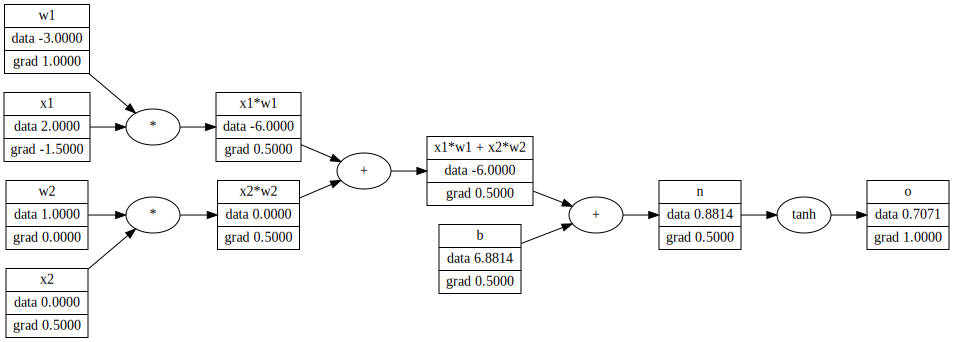

In [5]:
# inputs x1, x2
x1 = Value (2.0, label='x1')
x2 = Value (0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 + b; n.label='n' 
o= n.tanh(); o.label='o'
o.backward()
draw_dot(o)

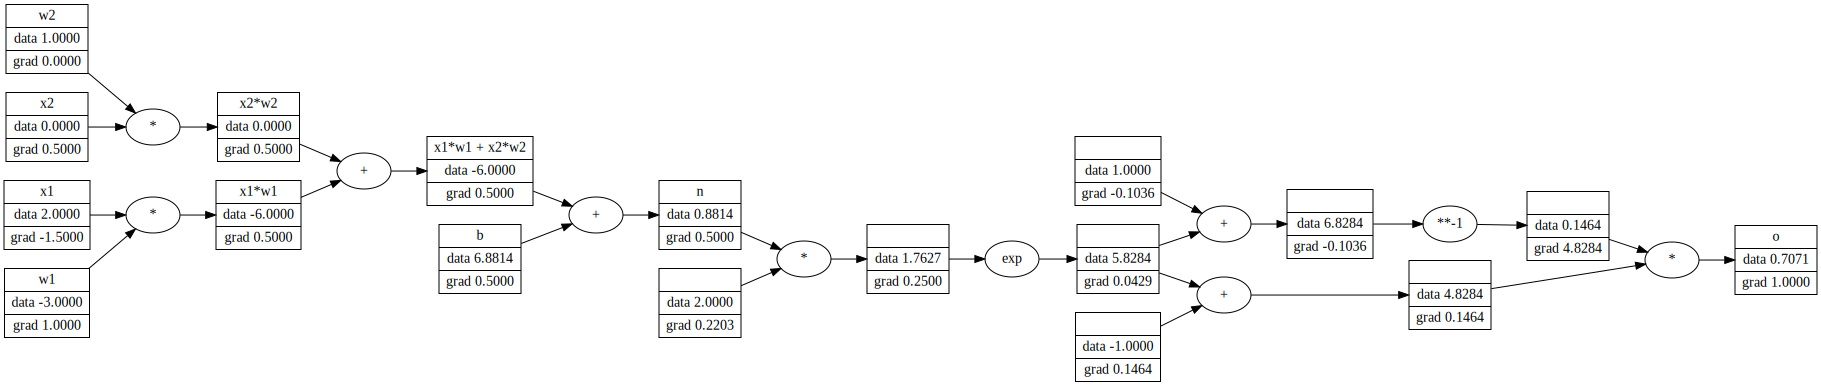

In [6]:
# inputs x1, x2
x1 = Value (2.0, label='x1')
x2 = Value (0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n' 
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

In [7]:
#minute mark 1h:39m:32s - do the above with PyTorch

In [8]:
import torch
import random

In [9]:
torch.Tensor([[1,2,3],[4,5,6]])#.shape #.dtype

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [10]:
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) #item return value element from data
o.backward()

print('---')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:
#minute mark 1h:44m:20s

In [12]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weights
        self.b = Value(random.uniform(-1,1)) #bias
        
    def __call__(self, x):
        # w * x +b
        # print(list(zip(self.w, x))) # iteration over tuples
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #activation
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.34341690928238383)

In [13]:
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs #return single element if only one
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #longer form of above one liner
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #return params
    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=-0.0827549578635465),
 Value(data=0.9722831405217452),
 Value(data=-0.9694704306801358)]

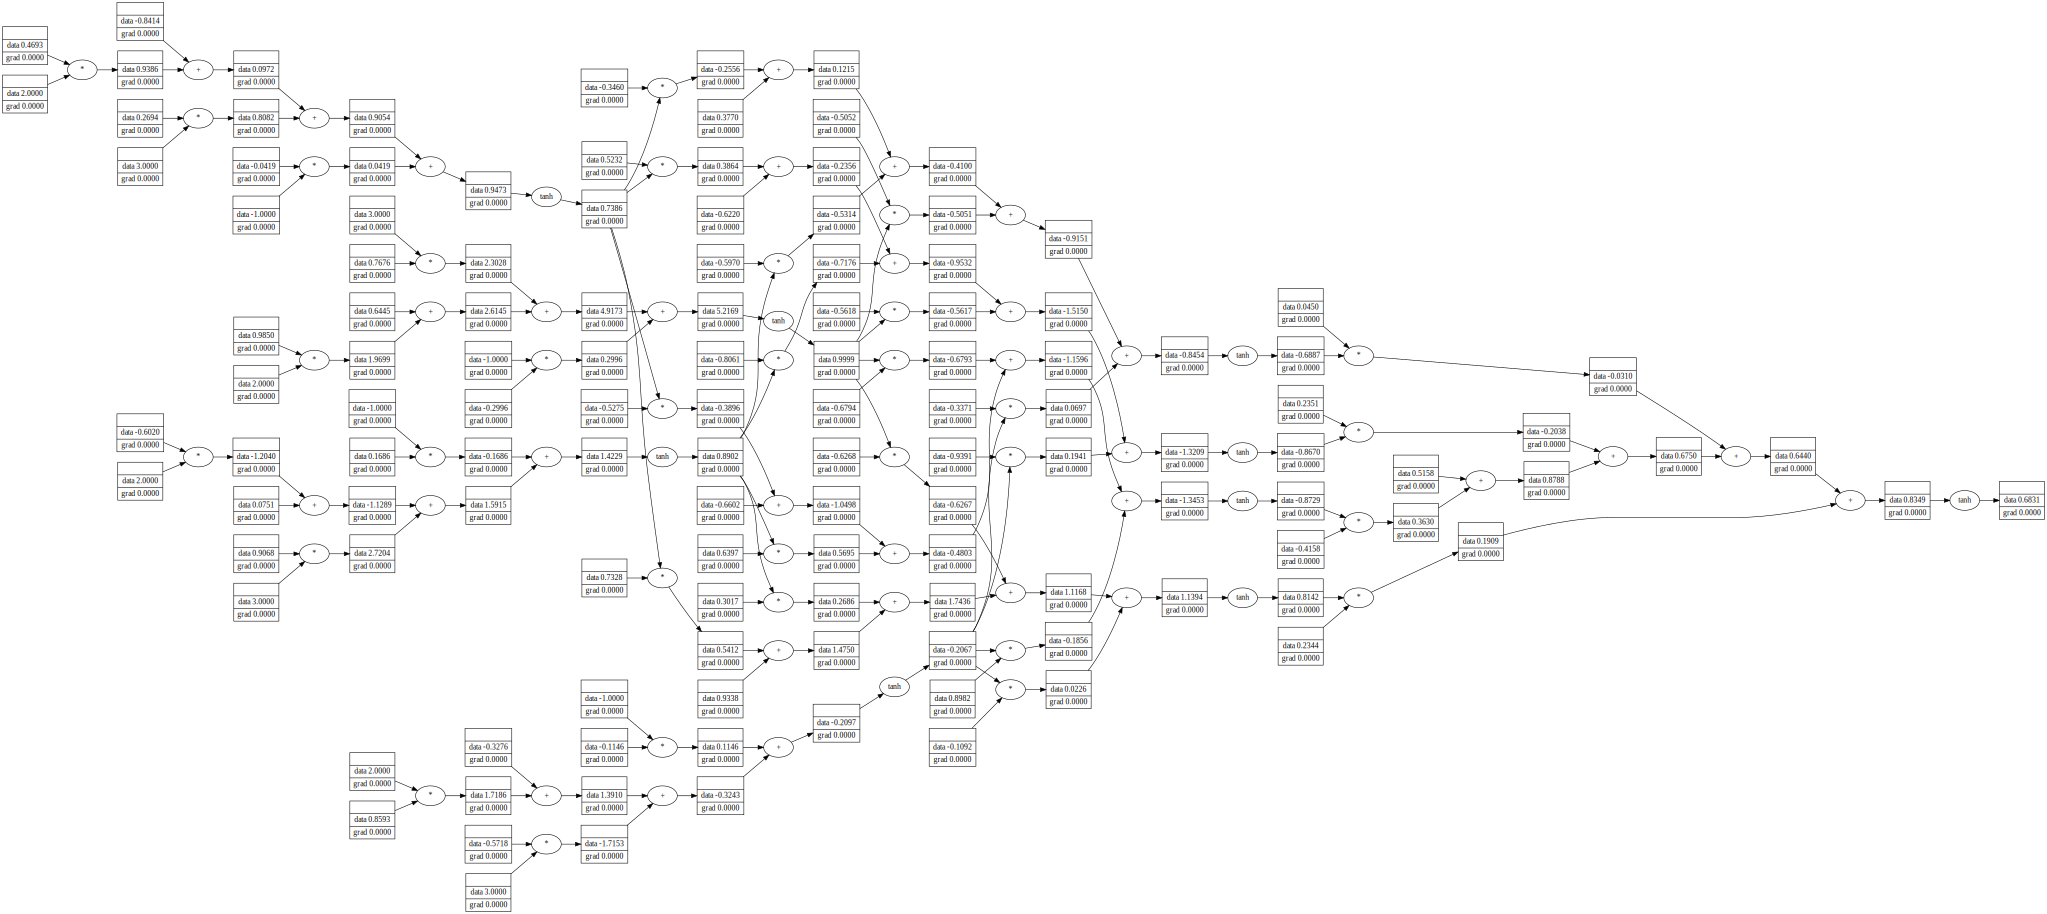

In [14]:
class MLP: #Multi Layer Perceptrons
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)
draw_dot(n(x))
#minute mark 1h:50m:24s

In [15]:
n.parameters()

[Value(data=0.4692953904662276),
 Value(data=0.2693927410767629),
 Value(data=-0.041947453681902),
 Value(data=-0.8414171455045645),
 Value(data=-0.6019848980411096),
 Value(data=0.9068018267081435),
 Value(data=0.16858779817122116),
 Value(data=0.07508236358711118),
 Value(data=0.984970594484273),
 Value(data=0.7675966529085694),
 Value(data=-0.2996441686236806),
 Value(data=0.6445271956777152),
 Value(data=0.8592991991143424),
 Value(data=-0.5717762136103246),
 Value(data=-0.11462234732645937),
 Value(data=-0.3275854042610611),
 Value(data=-0.527517394645656),
 Value(data=0.6397083570422106),
 Value(data=-0.679352756995675),
 Value(data=0.8981758584762538),
 Value(data=-0.66018038956835),
 Value(data=0.5232153977788914),
 Value(data=-0.8061133725265461),
 Value(data=-0.5617579401772537),
 Value(data=-0.9391438345307761),
 Value(data=-0.6220440021509148),
 Value(data=-0.3460267910862318),
 Value(data=-0.596954973285045),
 Value(data=-0.5051544306514075),
 Value(data=-0.337109518985619

In [16]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
] #inputs
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ydred = [n(x) for x in xs]
ydred

[Value(data=0.6831149418940016),
 Value(data=0.602142115858233),
 Value(data=0.6144776995822779),
 Value(data=0.604686990556043)]

In [17]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ydred)])
loss

Value(data=5.329669977290816)

In [18]:
loss.backward() #backward pass to evaluate grads

In [19]:
n.layers[0].neurons[0].w[0].data

0.4692953904662276

In [20]:
n.layers[0].neurons[0].w[0].grad

1.5579071035697183

In [21]:
#backward pass to evaluate grads
loss.backward() 

# nudging the data to right direction
for p in n.parameters():
    p.data += -0.01 * p.grad #grad of each parameter is the direction for the change of value (increase or decrease)

In [22]:
#forward pass
ydred = [n(x) for x in xs]

# check loss should be less now
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ydred)])
loss

Value(data=2.571477245950844)

In [23]:
for i in range(0, len(ydred)):
    print("Target :", ys[i], " | Guess :", ydred[i].data)

Target : 1.0  | Guess : -0.2634626800902191
Target : -1.0  | Guess : -0.43279151416771555
Target : -1.0  | Guess : -0.34678354739891065
Target : 1.0  | Guess : -0.3502074083643373


In [24]:
#minute mark 2h:08m:50s

# reinit input and the neural net
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
] #inputs
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
n = MLP(3, [4,4,1]) #neural net

# putting back and forward passes together in a training loop
# this is called a gradient descent
for k in range(1000):

    #forward pass
    ydred = [n(x) for x in xs]
    # loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ydred)]) # original code with squaring the loss
    loss = sum([((yout - ygt)**2)**0.5 for ygt, yout in zip(ys, ydred)]) 
    
    #zerograd bug fix as mentioned on minute mark 2h:11m:04s
    for p in n.parameters():
        p.grad = 0.0
    
    #backward pass
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)
    
    if loss.data < 10e-5:
        break    # break here when sufficient precision is achieved

# print results
for i in range(0, len(ydred)):
    print("Target :", ys[i], " | Guess :", ydred[i].data)
print("Solved with Neural Network with", len(n.parameters()), "no. parameters")

0 1.6279359090273977
1 1.350024775321629
2 1.0640392545454795
3 0.8227437953081843
4 0.6469164728443718
5 0.5244098190088139
6 0.43760795377048833
7 0.3739242003912765
8 0.32556033891138747
9 0.28772544011548284
10 0.2573892272734323
11 0.23256349969531587
12 0.21189714171480856
13 0.19444278878273358
14 0.17951779681426405
15 0.16661846959068016
16 0.1553653903223472
17 0.145467535203604
18 0.13669808672351924
19 0.1288777443648692
20 0.1218629640739115
21 0.1155375133014368
22 0.10980630316543782
23 0.10459081413653193
24 0.09982565599878856
25 0.09545594779467015
26 0.09143529899767999
27 0.08772423727485745
28 0.08428897195938878
29 0.08110041267948898
30 0.07813338390729607
31 0.07536599137510835
32 0.07277910725378911
33 0.07035594897165987
34 0.0680817324361922
35 0.06594338480070905
36 0.063929305208969
37 0.0620291644445069
38 0.060233736317389486
39 0.058534755088617385
40 0.05692479437085762
41 0.055397163833401986
42 0.053945820738361294
43 0.052565293888187536
44 0.0512506

395 0.004722128282789728
396 0.004709454850720718
397 0.004696847973287066
398 0.00468430713260326
399 0.0046718318161097505
400 0.004659421516507445
401 0.004647075731689432
402 0.004634793964674477
403 0.0046225757235436316
404 0.004610420521374947
405 0.004598327876180308
406 0.004586297310844922
407 0.004574328353064594
408 0.0045624205352854386
409 0.004550573394645374
410 0.004538786472916279
411 0.00452705931644426
412 0.004515391476094588
413 0.0045037825071955195
414 0.004492231969482563
415 0.004480739427045521
416 0.004469304448273426
417 0.004457926605803242
418 0.004446605476467025
419 0.004435340641240959
420 0.004424131685195731
421 0.004412978197445905
422 0.004401879771101069
423 0.0043908360032178795
424 0.004379846494753092
425 0.00436891085051494
426 0.004358028679119386
427 0.0043471995929417195
428 0.004336423208074147
429 0.004325699144280493
430 0.004315027024952789
431 0.004304406477067979
432 0.004293837131145395
433 0.0042833186212059005
434 0.004272850584729

729 0.0024724625033695213
730 0.0024689092121369383
731 0.0024653659780927706
732 0.0024618327588995514
733 0.0024583095124574017
734 0.0024547961969006993
735 0.002451292770596636
736 0.0024477991921437736
737 0.002444315420370602
738 0.00244084141433365
739 0.0024373771333160432
740 0.002433922536826172
741 0.0024304775845954696
742 0.0024270422365777478
743 0.002423616452946642
744 0.00242020019409539
745 0.002416793420634722
746 0.0024133960933905296
747 0.0024100081734031997
748 0.002406629621927503
749 0.0024032604004283753
750 0.002399900470580807
751 0.002396549794269398
752 0.0023932083335858056
753 0.0023898760508267447
754 0.0023865529084942105
755 0.002383238869293147
756 0.0023799338961301153
757 0.0023766379521121817
758 0.002373351000545143
759 0.00237007300493286
760 0.0023668039289754805
761 0.0023635437365676637
762 0.0023602923917988017
763 0.0023570498589498
764 0.0023538161024935222
765 0.0023505910870921243
766 0.0023473747775962783
767 0.0023441671390451724
768 0

In [26]:
#use the trained NN to make new predictions from other inputs
xold1 = [2.0, 3.0, -1.0]
xold2 = [3.0, -1.0, 0.5]
xold3 = [0.5, 1.0, 1.0]
xold4 = [1.0, 1.0, -1.0]
xnew1 = [0.75, 1.0, 0]
n(xold2)

Value(data=-0.9996385398867796)

In [27]:
n(xnew1)

Value(data=-0.6422331685134418)